In [1]:
import sys
import os
sys.path.append("..") 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.preprocessing import Preprocessor
from src.lstm_forecasting import LSTMForecaster, LSTMTimeSeries
from sklearn.metrics import mean_squared_error
from preprocess import *
from add_features import *
from models import *
# Pour ne pas afficher de warnings inutiles
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
champs_elysees_df = pd.read_csv('../data/traffic/champs_elysees.csv', sep=";")
# convention_df = pd.read_csv('../data/traffic/convention.csv', sep=";")
# sts_peres_df = pd.read_csv('../data/traffic/sts_peres.csv', sep=";")

weather_df = pd.read_csv('../data/weather/weather_paris.csv')
holidays_df = pd.read_csv('../data/events/french_holidays.csv', sep=";")
football_matches_df = pd.read_csv('../data/events/football_matches_2024_2025.csv')

In [3]:
# champs_elysees_df.isna().sum()/champs_elysees_df["Identifiant arc"].count()

In [4]:
preprocessor = Preprocessor(df=champs_elysees_df)

# On applique ton pipeline de preprocessing
df_processed = preprocessor.fit_transform(holidays_df=holidays_df, weather_df=weather_df, sports_df=football_matches_df)

print("Preprocessed Data :", df_processed.shape)
display(df_processed.sample(5))


Preprocessed Data : (8627, 45)


,Identifiant arc,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,Libelle noeud aval,Etat arc,...,wind_speed_10m (km/h),weather_code (wmo code),surface_pressure (hPa),cloud_cover (%),apparent_temperature (°C),rain (mm),sport_event_name,is_sport_event,Débit horaire_outlier_iqr,Taux d'occupation_outlier_iqr
Date et heure de comptage,,,,,,,,,,,,,,,,,,,,,
2025-06-28 02:00:00,4264,AV_Champs_Elysees,1079.0,18.08056,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
2025-03-01 19:00:00,4264,AV_Champs_Elysees,806.0,17.63333,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,NaN,NaN,NaN,NaN,NaN,NaN,Ligue 1 : Racing Club de Lens vs Le Havre AC,True,False,False
2025-10-01 00:00:00,4264,AV_Champs_Elysees,770.0,13.07833,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,5.8,0.0,1020.9,0.0,11.7,0.0,NaN,False,False,False
2025-03-27 21:00:00,4264,AV_Champs_Elysees,861.0,15.69889,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,NaN,NaN,NaN,NaN,NaN,NaN,La Liga : FC Barcelona vs CA Osasuna,True,False,False
2025-09-28 09:00:00,4264,AV_Champs_Elysees,296.0,8.43167,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,1.4,0.0,1014.9,7.0,12.9,0.0,NaN,False,False,False


In [5]:
df_champs_lstm=pipeline(champs_elysees_df, window=3, fill_hours=True)
df_champs_xgb = pipeline(champs_elysees_df,window=3,fill_hours=False)

8627
9524


# LSTM Forecasting

In [ ]:
forecaster = LSTMForecaster(
    seq_length= 168,  # 7 historical days
    pred_length=72,  # prediction 72h in advance
    lstm_units=64,
    dropout=0.2,
    use_weather=False,
    use_holidays=False,
    use_sport=False,
    use_outliers=False
)

# Preparation of sequences
X_train, X_test, y_train, y_test = forecaster.prepare_data(df_lisse)

# Training
history = forecaster.train(
    X_train, y_train,
    X_test, y_test,
    epochs=10, batch_size=32
)
y_test_inv, y_pred_inv = forecaster.evaluate(X_test, y_test)

# Visualisation on the first 72 hours
forecaster.plot_predictions(y_test_inv, y_pred_inv, n_plot=150)

In [ ]:
# Concaténer train + test pour la CV (on prend tout)
X_all = np.concatenate([X_train, X_test], axis=0)
y_all = np.concatenate([y_train, y_test], axis=0)

forecaster.time_series_cv(X_all, y_all, n_splits=5, epochs=5, batch_size=32)

# XGBoost model

In [6]:
from src.xgb_forecasting import XGBoostModel

Train set: (8387, 25), Test set: (72, 25) (72 hours)
Débit horaire : RMSE = 98.35, Mean = 779.03, Relative Error = 12.63%
Taux d'occupation : RMSE = 4.70, Mean = 17.27, Relative Error = 27.23%


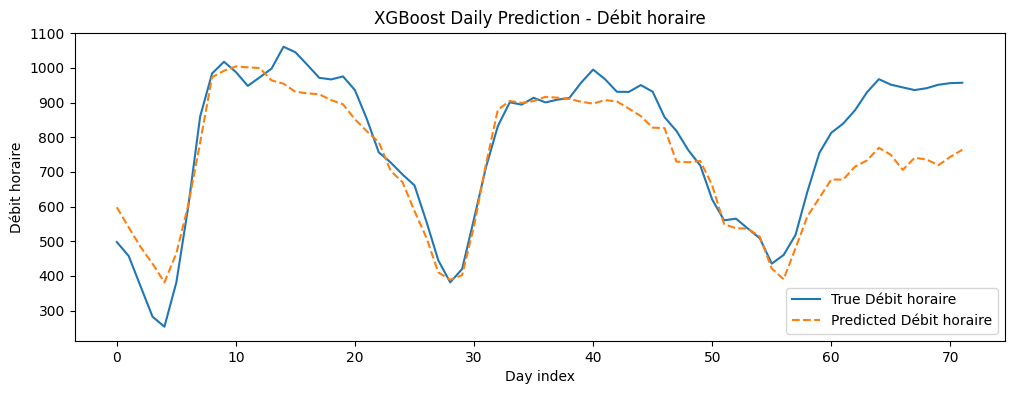

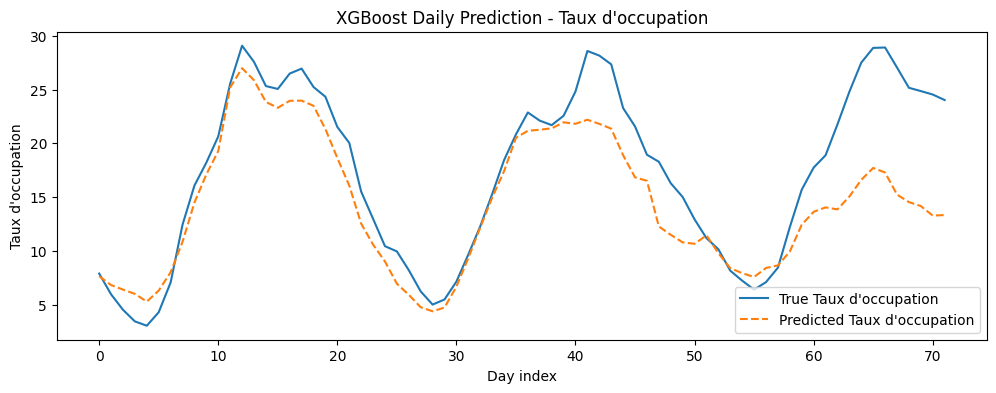

In [8]:
targets = ['Débit horaire', "Taux d'occupation"]
features_xgb = ['is_holiday',
                'is_sport_event',
                'temperature_2m (°C)','wind_speed_10m (km/h)',
                'precipitation (mm)','cloud_cover (%)'] 

features_xgb = [
        'hour_sin', 'hour_cos', 
        'weekday_sin', 'weekday_cos', 
        'month_sin', 'month_cos', 
        'dayofyear_sin', 'dayofyear_cos',
        'is_weekend', 'is_holiday',
        'Vacances Scolaires Paris', 
        'temperature_2m (°C)', 'wind_speed_10m (km/h)',
        'precipitation (mm)', 'cloud_cover (%)',
        'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
        "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"]

df_xgb = df_champs_xgb.copy()

# Lags à créer (en heures)
lags_hours = [72,168]  # 1h, 3h, 1 jour, 2 jours, 1 semaine

for target in targets:
    for lag in lags_hours:
        col_name = f"{target}_lag_{lag}h"
        df_xgb[col_name] = df_xgb[target].shift(lag)
        features_xgb.append(col_name)

# Supprimer les lignes contenant des NaN générés par les lags
df_xgb = df_xgb.dropna(subset=[f"{t}_lag_{lag}h" for t in targets for lag in lags_hours] + targets).copy()


xgb_model = XGBoostModel(df_xgb, features_xgb, targets)
xgb_model.prepare_data(horizon=72)

xgb_model.fit()

# Prediction on the test set
y_test, y_pred = xgb_model.evaluate()

# Plot
for i, target in enumerate(targets):
    plt.figure(figsize=(12,4))
    plt.plot(y_test[:, i], label=f"True {target}")
    plt.plot(y_pred[:, i], '--', label=f"Predicted {target}")
    plt.title(f"XGBoost Daily Prediction - {target}")
    plt.xlabel("Day index")
    plt.ylabel(target)
    plt.legend()
    plt.show()



In [12]:
cv_results = xgb_model.cross_validate(n_splits=5)

Débit horaire : CV RMSE mean = 146.37, std = 19.79
Taux d'occupation : CV RMSE mean = 4.55, std = 0.84


In [16]:
cv_results = xgb_model.cross_validate(n_splits=5)

Débit horaire : CV RMSE mean = 177.67, std = 23.58
Taux d'occupation : CV RMSE mean = 7.31, std = 1.64


# Hybrid LSTM + XGBoost model 

In [10]:
## Hybrid LSTM + XGBoost model

### LSTM for short-term patterns
lstm_model = LSTMForecaster(
    seq_length= 168,  # 7 historical days
    pred_length=72,  # prediction 72h in advance
    lstm_units=64,
    dropout=0.2,
    use_weather=False,
    use_holidays=False,
    use_sport=False
)

# Preparation of sequences
X_train, X_test, y_train, y_test = lstm_model.prepare_data(df_processed)

# Training
history = lstm_model.train(
    X_train, y_train,
    X_test, y_test,
    epochs=5, batch_size=32
)

# Predictions LSTM
y_test_inv, y_pred_inv = lstm_model.evaluate(X_test, y_test)

### XGBoost for long-term patterns
# Compute daily averages
# daily_df = df_processed.groupby('date').agg({
#     'Débit horaire':'mean',
#     "Taux d'occupation":'mean',
#     'is_holiday':'first',
#     'is_sport_event':'first',
#     'temperature_2m (°C)':'mean',
#     'wind_speed_10m (km/h)':'mean',
#     'precipitation (mm)':'mean',
#     'cloud_cover (%)':'mean'
# }).reset_index()

# Features for XGBoost
features_xgb = ['is_holiday','is_sport_event','temperature_2m (°C)',
                'wind_speed_10m (km/h)','precipitation (mm)','cloud_cover (%)']


df_xgb = df_processed.copy()
df_xgb['lag_1d'] = df_xgb['Débit horaire'].shift(24)
df_xgb['lag_1w'] = df_xgb['Débit horaire'].shift(24*7)

features_xgb += ['lag_1d', 'lag_1w']


# Instanciate XGBoost
xgb_model = XGBoostModel(df_xgb, features_xgb, lstm_model.targets)
xgb_model.prepare_data(horizon=72)
xgb_model.fit()

# Predictions XGBoost (long-term)
y_pred_xgb = xgb_model.predict()


Epoch 1/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 0.0234 - val_loss: 0.0131
Epoch 2/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - loss: 0.0127 - val_loss: 0.0106
Epoch 3/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - loss: 0.0117 - val_loss: 0.0105
Epoch 4/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 0.0114 - val_loss: 0.0110
Epoch 5/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - loss: 0.0111 - val_loss: 0.0110
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
Débit horaire : RMSE = 216.27, Mean = 738.55, Relative error = 29.28%
Taux d'occupation : RMSE = 8.23, Mean = 16.53, Relative error = 49.81%
Train set: (1417, 8), Test set: (72, 8) (72 hours)


In [11]:
# Combine LSTM and XGBoost predictions
y_test_inv, y_pred_lstm_array = lstm_model.evaluate(X_test, y_test)
print("LSTM Prediction Array Shape :", y_pred_lstm_array.shape)
y_pred_lstm_hourly = y_pred_lstm_array[-1, :, :]

alpha = 0.3
y_pred_final = alpha * y_pred_lstm_hourly + (1-alpha) * y_pred_xgb
print("Final Prediction Shape :", y_pred_final.shape)

y_true = y_test_inv[-1, :, :]  # real 72h for the last batch of LSTM
y_pred = y_pred_final           # 72h combined LSTM + XGBoost

for i, target in enumerate(lstm_model.targets):
    rmse = np.sqrt(np.mean((y_true[:, i] - y_pred[:, i])**2))
    mean_val = np.mean(y_true[:, i])
    rel_error = 100 * rmse / mean_val
    print(f"{target} : RMSE = {rmse:.2f}, Mean = {mean_val:.2f}, Relative Error = {rel_error:.2f}%")

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Débit horaire : RMSE = 216.27, Mean = 738.55, Relative error = 29.28%
Taux d'occupation : RMSE = 8.23, Mean = 16.53, Relative error = 49.81%
LSTM Prediction Array Shape : (1678, 72, 2)
Final Prediction Shape : (72, 2)
Débit horaire : RMSE = 265.06, Mean = 772.65, Relative Error = 34.31%
Taux d'occupation : RMSE = 9.53, Mean = 17.08, Relative Error = 55.82%


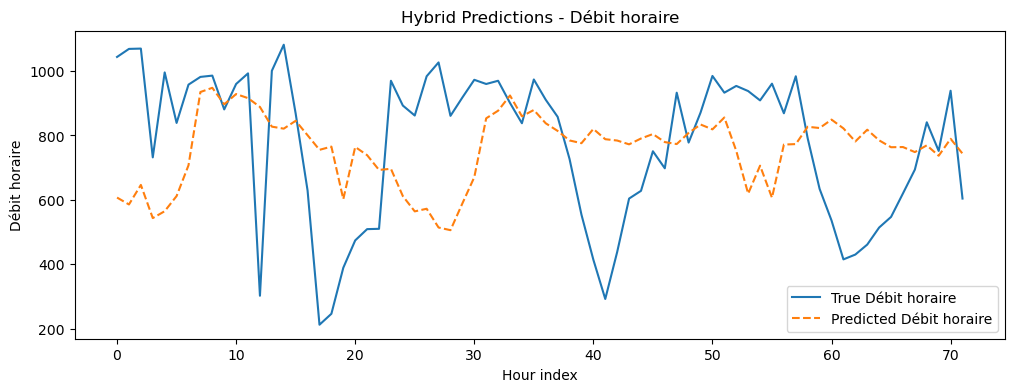

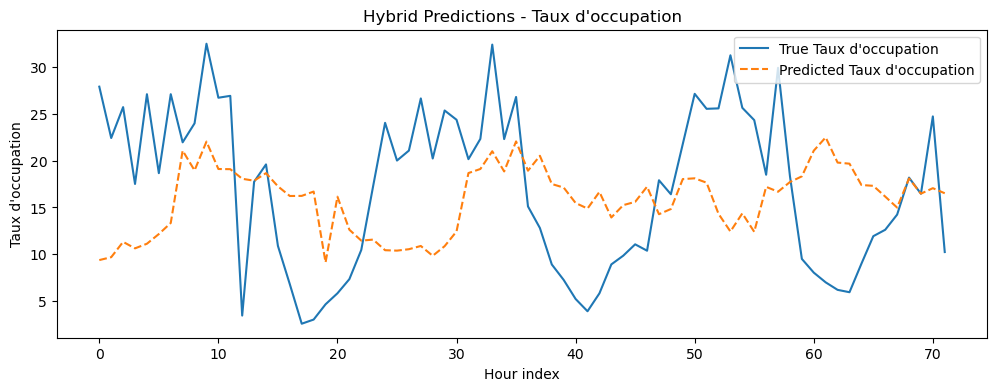

In [12]:
# Plot
for i, target in enumerate(targets):
    plt.figure(figsize=(12,4))
    plt.plot(y_test_inv[-1, :, :][:, i], label=f"True {target}")
    plt.plot(y_pred_final[:, i], '--', label=f"Predicted {target}")
    plt.title(f"Hybrid Predictions - {target}")
    plt.xlabel("Hour index")
    plt.ylabel(target)
    plt.legend()
    plt.show()

In [32]:
features = [
    'hour_sin', 'hour_cos', 
    'weekday_sin', 'weekday_cos', 
    'month_sin', 'month_cos', 
    'dayofyear_sin', 'dayofyear_cos',
    'is_weekend', 'is_holiday',
    'Vacances Scolaires Paris', 
    'temperature_2m (°C)', 'wind_speed_10m (km/h)',
    'precipitation (mm)', 'cloud_cover (%)',
    'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
    "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"
]

targets = ['Débit horaire', "Taux d'occupation"]

features = [
        'hour_sin', 'hour_cos', 
        'weekday_sin', 'weekday_cos', 
        'month_sin', 'month_cos', 
        'dayofyear_sin', 'dayofyear_cos',
        'is_weekend', 'is_holiday',
        'Vacances Scolaires Paris', 
        'temperature_2m (°C)', 'wind_speed_10m (km/h)',
        'precipitation (mm)', 'cloud_cover (%)',
        'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
        "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"]


In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# -----------------------------
# 1. Features et targets
# -----------------------------
features = [
    'hour_sin', 'hour_cos', 
    'weekday_sin', 'weekday_cos', 
    'month_sin', 'month_cos', 
    'dayofyear_sin', 'dayofyear_cos',
    'is_weekend', 'is_holiday',
    'Vacances Scolaires Paris', 
    'temperature_2m (°C)', 'wind_speed_10m (km/h)',
    'precipitation (mm)', 'cloud_cover (%)',
    'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
    "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"
]

targets = ['Débit horaire', "Taux d'occupation"]

# -----------------------------
# 2. Séparer les 72 dernières heures pour évaluation finale
# -----------------------------
final_eval_size = 72
train_val_df = df_lisse.iloc[:-final_eval_size].copy()
final_eval_df = df_lisse.iloc[-final_eval_size:].copy()

# -----------------------------
# 3. Normalisation
# -----------------------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_val_scaled = scaler_X.fit_transform(train_val_df[features])
y_train_val_scaled = scaler_y.fit_transform(train_val_df[targets])

X_final_eval_scaled = scaler_X.transform(final_eval_df[features])
y_final_eval_scaled = scaler_y.transform(final_eval_df[targets])

# -----------------------------
# 4. Création des séquences
# -----------------------------
def create_sequences(X, y, seq_length=168, pred_length=72):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length - pred_length + 1):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length:i+seq_length+pred_length])
    return np.array(X_seq), np.array(y_seq)

SEQ_LENGTH = 168
PRED_LENGTH = 72
X_seq, y_seq = create_sequences(X_train_val_scaled, y_train_val_scaled, SEQ_LENGTH, PRED_LENGTH)

# -----------------------------
# 5. Fonction d'évaluation
# -----------------------------
def evaluate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse_mean = rmse / np.mean(y_true)
    return rmse, mape, rmse_mean

# -----------------------------
# 6. Cross-validation temporelle
# -----------------------------
tscv = TimeSeriesSplit(n_splits=5)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_seq)):
    X_train, X_val = X_seq[train_idx], X_seq[val_idx]
    y_train, y_val = y_seq[train_idx], y_seq[val_idx]

    # Définir le modèle LSTM seq-to-seq
    model = Sequential()
    model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(PRED_LENGTH * y_train.shape[2]))  # sortie aplatie
    model.compile(optimizer='adam', loss='mse', metrics=['mape','mae'])

    # Entraînement avec early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(
        X_train, y_train.reshape(y_train.shape[0], -1),
        validation_data=(X_val, y_val.reshape(y_val.shape[0], -1)),
        epochs=20,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )

    # Prédiction sur validation
    y_val_pred_scaled = model.predict(X_val)
    y_val_pred_scaled = y_val_pred_scaled.reshape(y_val.shape)  # reshape en (n_samples, pred_length, n_targets)

    # Inverse scaling
    y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, len(targets)))
    y_val_true = scaler_y.inverse_transform(y_val.reshape(-1, len(targets)))

    rmse, mape, rmse_mean = evaluate_metrics(y_val_true, y_val_pred)
    print(f"Fold {fold+1} - RMSE: {rmse:.2f}, MAPE: {mape:.2%}, RMSE/mean: {rmse_mean:.2%}")

# -----------------------------
# 7. Évaluation finale sur les 72 derniers points
# -----------------------------

model_final = Sequential()
model_final.add(LSTM(128, input_shape=(SEQ_LENGTH, len(features))))
model_final.add(Dropout(0.2))
model_final.add(Dense(64, activation='relu'))
model_final.add(Dense(PRED_LENGTH * len(targets)))
model_final.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entraînement sur toutes les séquences disponibles
model_final.fit(
    X_seq, y_seq.reshape(y_seq.shape[0], -1),
    epochs=30,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)],
    verbose=1
)
X_last_seq = X_train_val_scaled[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, len(features))
y_pred_scaled = model_final.predict(X_last_seq)
y_pred_scaled = y_pred_scaled.reshape(PRED_LENGTH, len(targets))
y_pred = scaler_y.inverse_transform(y_pred_scaled)

final_eval_true = final_eval_df[targets].values
rmse_final, mape_final, rmse_mean_final = evaluate_metrics(final_eval_true, y_pred)
print("\nÉvaluation finale sur les 72 dernières heures :")
print(f"RMSE: {rmse_final:.2f}, MAPE: {mape_final:.2%}, RMSE/mean: {rmse_mean_final:.2%}")


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.9542 - mae: 0.8151 - mape: 211.4431 - val_loss: 1.0041 - val_mae: 0.8171 - val_mape: 165.3433
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.5915 - mae: 0.6102 - mape: 259.2303 - val_loss: 0.7432 - val_mae: 0.6613 - val_mape: 163.1018
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.4170 - mae: 0.4891 - mape: 332.6750 - val_loss: 0.7558 - val_mae: 0.6632 - val_mape: 239.0583
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.3205 - mae: 0.4255 - mape: 311.8133 - val_loss: 0.8513 - val_mae: 0.7064 - val_mape: 255.6551
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.2654 - mae: 0.3846 - mape: 274.7526 - val_loss: 1.1297 - val_mae: 0.7885 - val_mape: 350.4658
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.2327 - mae: 0.3575 - mape: 252.4550 - val_loss: 1.3128 - val_mae: 0.8206 - val_mape: 400.2259
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.2111 - ma

KeyboardInterrupt: 

In [47]:
final_eval_size = 72
seq_length = 168

# On garde les 168h avant la période finale pour le contexte
context_start = -(seq_length + final_eval_size)
context_end = -final_eval_size

train_val_df = df_champs.iloc[:-final_eval_size].copy()   # tout ce qui est AVANT le contexte
#context_df = df_champs.iloc[context_start:context_end].copy()  # les 168h de contexte
final_eval_df = df_champs.iloc[-final_eval_size:].copy()       # les 72h à prédire

print(f"Train: {train_val_df.shape},  Eval: {final_eval_df.shape}")

lstm_model = LSTMTimeSeries(
    features=features,
    targets=targets,
    seq_length=seq_length,
    pred_length=final_eval_size
)

Train: (9452, 55),  Eval: (72, 55)


In [59]:
lstm_model.cross_validate(train_val_df,epochs=1,batch_size=32)

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step

===== Fold 1 =====
Débit horaire             RMSE: 271.68, MEAN: 703.67, MAPE: 226.52%, RMSE/mean: 38.61%
Taux d'occupation         RMSE: 9.48, MEAN: 15.46, MAPE: 69.85%, RMSE/mean: 61.32%
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step

===== Fold 2 =====
Débit horaire             RMSE: 232.48, MEAN: 783.03, MAPE: 39.77%, RMSE/mean: 29.69%
Taux d'occupation         RMSE: 4.81, MEAN: 13.89, MAPE: 49.27%, RMSE/mean: 34.63%
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step

===== Fold 3 =====
Débit horaire             RMSE: 212.57, MEAN: 745.78, MAPE: 50.46%, RMSE/mean: 28.50%
Taux d'occupation         RMSE: 5.54, MEAN: 15.46, MAPE: 62.49%, RMSE/mean: 35.81%
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step

===== Fold 4 =====
Débit horaire             RMSE: 189.74, MEAN: 730.42, MAPE: 30.73%, RMSE/mean: 25.98%
Taux d'occupation         RMSE: 7.53, MEAN: 17.36, MAPE: 49.15%, RMSE/mean: 43.36%
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step

===== Fold 5 =====
Débit horaire          

In [50]:
lstm_model.train_final(train_val_df, epochs=30, batch_size=32)

Epoch 1/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - loss: 0.5656 - mae: 0.5486 - mape: 236.7128
Epoch 2/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - loss: 0.3695 - mae: 0.4326 - mape: 231.7763
Epoch 3/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - loss: 0.3196 - mae: 0.4003 - mape: 217.4209
Epoch 4/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - loss: 0.2836 - mae: 0.3787 - mape: 209.2097
Epoch 5/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - loss: 0.2425 - mae: 0.3486 - mape: 189.5402
Epoch 6/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - loss: 0.2263 - mae: 0.3361 - mape: 184.7078
Epoch 7/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - loss: 0.2155 - mae: 0.3262 - mape: 178.6018
Epoch 8/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - loss: 0.2088 - mae: 0.3237 - mape: 181.8435
Epoch 9/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - loss: 0.1860 - mae: 0.3063 - mape: 168.9271
Epoch 10/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - loss: 0.1762 - mae: 0.2986 - mape: 165.9152

In [60]:
y_pred = lstm_model.predict(train_val_df[-168:])  # entrée : les 168 dernières heures avant la période finale

print("\n📊 Évaluation finale par target (sans fuite de données) :")
for i, target_name in enumerate(targets):
    y_true_i = final_eval_df[targets[i]].values
    y_pred_i = y_pred[:, i]
    metrics = LSTMTimeSeries.evaluate_metrics(y_true_i, y_pred_i, target_name=target_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

📊 Évaluation finale par target (sans fuite de données) :
Débit horaire             RMSE: 59.05, MEAN: 779.03, MAPE: 7.07%, RMSE/mean: 7.58%
Taux d'occupation         RMSE: 2.05, MEAN: 17.27, MAPE: 11.23%, RMSE/mean: 11.88%


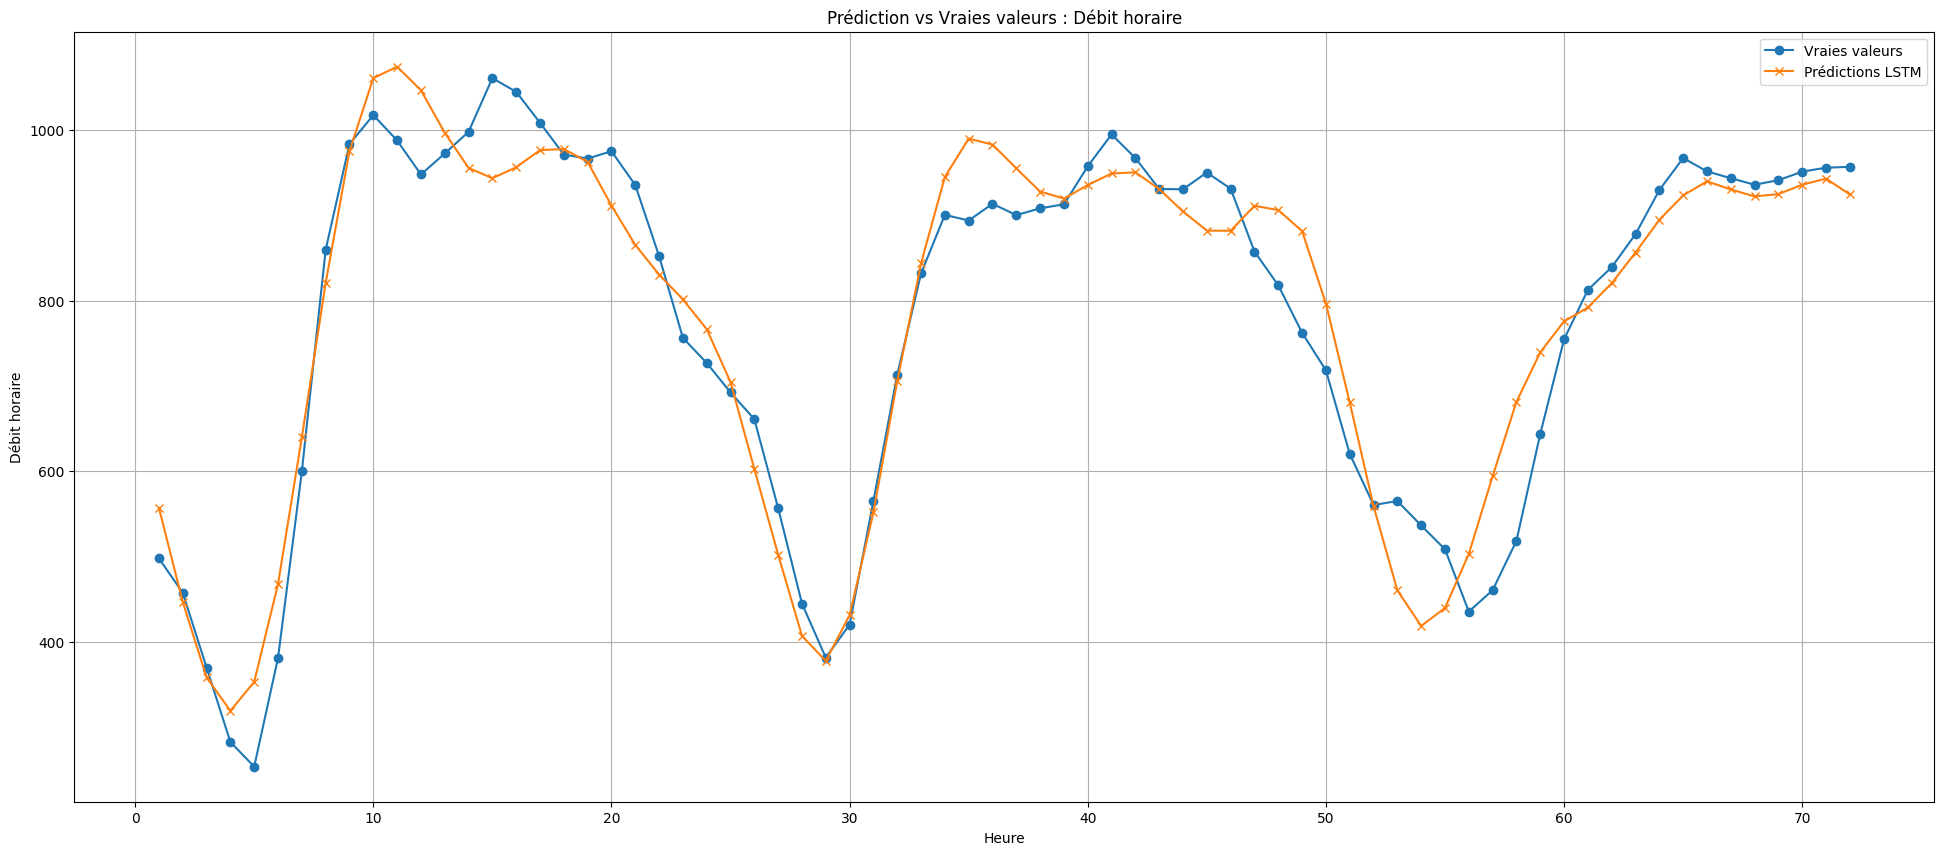

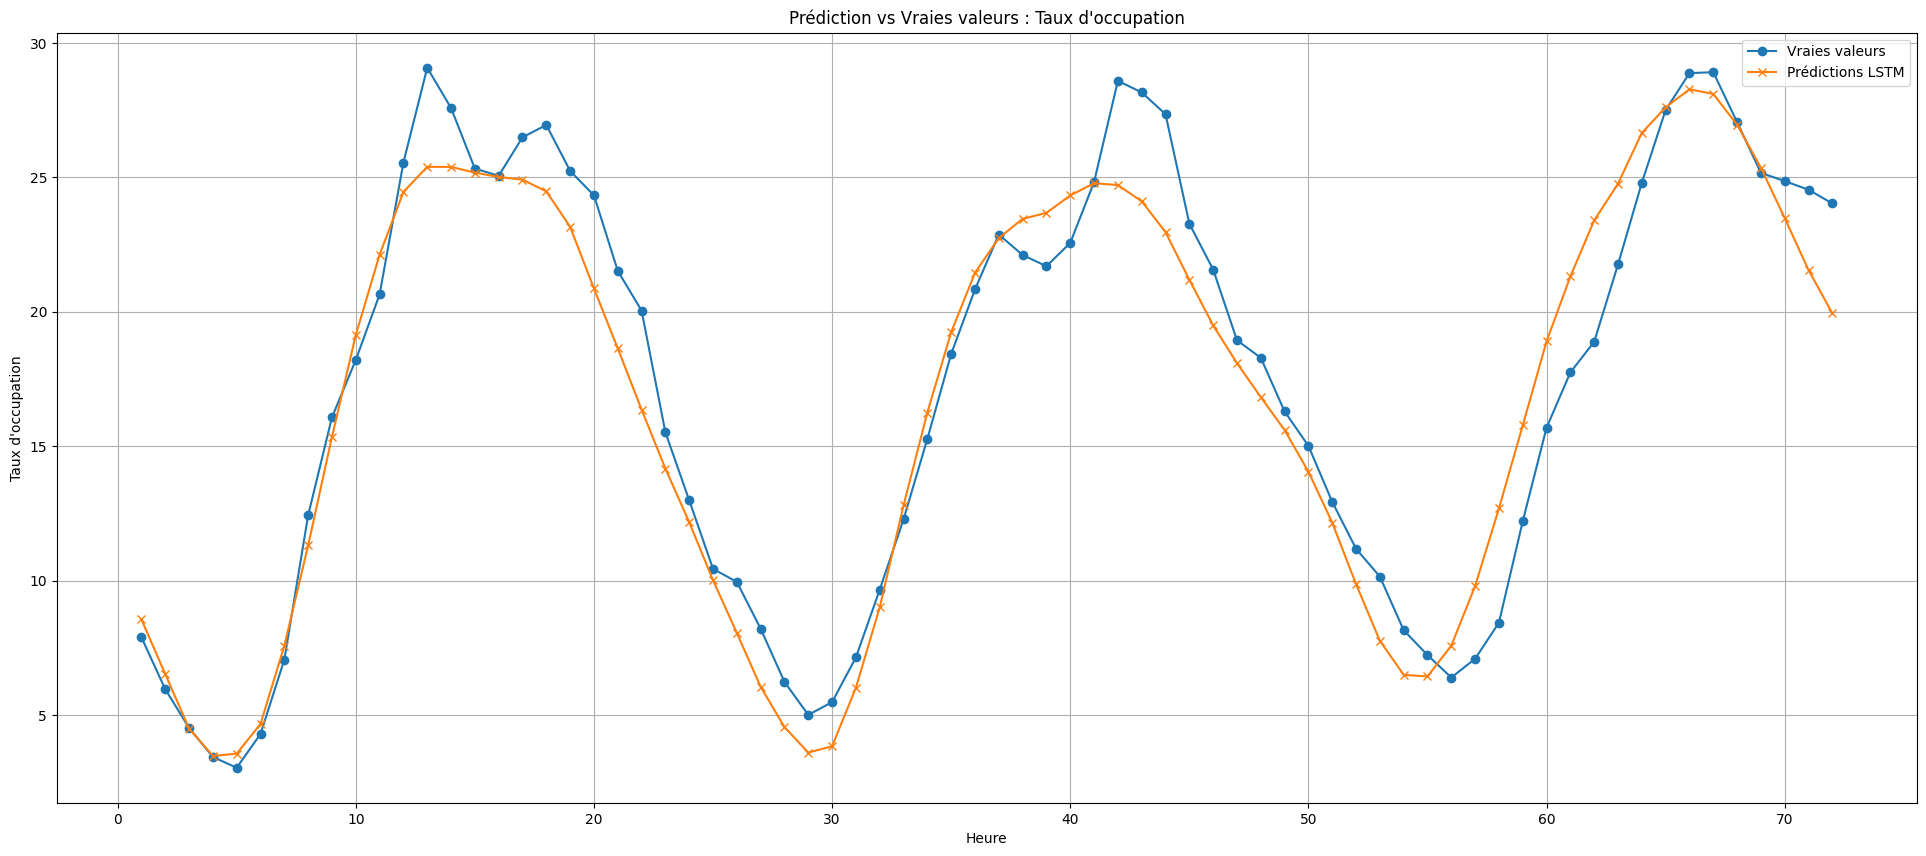

In [61]:
hours = np.arange(1, 73)
for i, target in enumerate(targets):
    plt.figure(figsize=(24,10))
    plt.plot(hours, final_eval_true[:, i], marker='o', label='Vraies valeurs')
    plt.plot(hours, y_pred[:, i], marker='x', label='Prédictions LSTM')
    plt.title(f'Prédiction vs Vraies valeurs : {target}')
    plt.xlabel('Heure')
    plt.ylabel(target)
    plt.grid(True)
    plt.legend()
    plt.show()
